# Application: Obliquity Pacing of Pleistocene Ice Ages

In this lab we will apply hypothesis testing to evaluate whether obliquity might be pacing the Pleistocene Ice Ages.
This lab broadly follows <a href="https://doi.org/10.1038/nature03401">Huybers and Wunsch (2004)</a>. 

Since the data from that paper is not available, we will use a slightly different dataset and technique. Ideally, the result of our hypothesis test should not be too sensitive to small methodological differences. 

In [1]:
#%reset 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import optimize
import numpy as np

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Data: Pleistocene $\delta^{18}$O and Obliquity

We'll use the Lisiecky and Raymo stack of sediment $\delta^{18}O$ measurements, which is representative of ice volume during the Pleistocene Ice Ages. 

We'll use the Berger '91 Orbital solution to look at variations in Obliquity over the last 700kyrs.

In [2]:
# Let's load the data and take a look at it
url='https://cristi.web.illinois.edu/wp-content/uploads/2021/09/LR04.csv'
df_LR04   =pd.read_csv(url);
age=df_LR04['age']
d18=df_LR04['d18O']

# Load orbital solutions
url='https://cristi.web.illinois.edu/wp-content/uploads/2021/09/orbital.csv'
df_orbital=pd.read_csv(url);
orb_age=-df_orbital['age']
obliq  =df_orbital['obliquity']

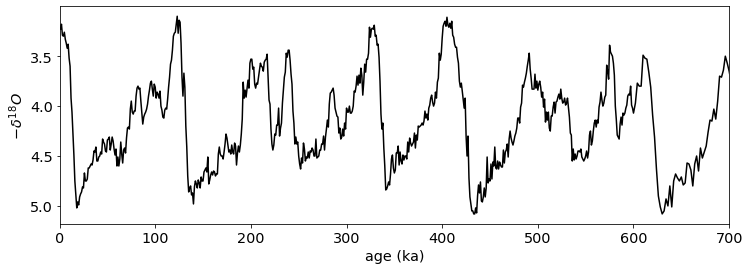

In [3]:
fig,ax=plt.subplots(1,1,figsize=[12,4])
ax.plot(age,d18,'k')
ax.set_ylabel('$-\delta^{18}O$');
ax.set_xlim(0,700)
ax.set_xlabel('age (ka)')
ax.invert_yaxis()

Following hallowed paleoclimate tradition we will simply identify the mid-points of terminations by hand. We'll then visualize the data

In [4]:
terminations=np.asarray([622, 534, 423, 336, 244, 220, 132, 13])

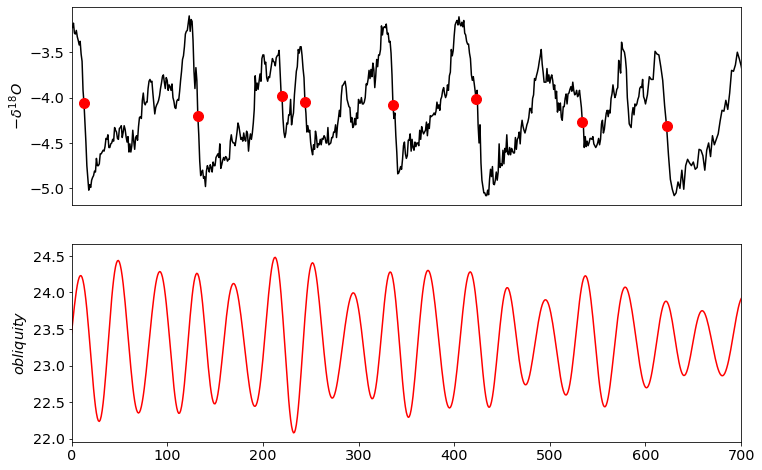

In [5]:
fig,ax=plt.subplots(2,1,figsize=[12,8])
ax[0].plot(age,-d18,'k')
ax[0].set_ylabel('$-\delta^{18}O$');
ax[0].set_xticks([])
#ax[0].set_ylim(bottom=-1.1,top=1.1)

# plot terminations
terminations_df=df_LR04[df_LR04['age'].isin(terminations)]
ax[0].plot(terminations_df['age'],-terminations_df['d18O'],'ro',markersize=10)

ax[1].plot(orb_age,obliq,'r')
ax[1].set_ylabel('$obliquity$');

for j in range(2):
    ax[j].set_xlim(left=0,right=700)

# Phase of terminations
Next, we'll need to compute the phase of obliquity at the moment of terminations.
Huybers Wunsch 2004 mention a "stroboscopic" sampling of obliquity, but do not give much detail. 
So instead, we'll use a very rough methodology illustrated below, where we take advantage of the fact that obliquity varies with a period of **aproximately** 41kyr.
## Illustration of phase calculation:
We'll take at a point in time $t_0$ and we'll look at the previous $41$ kyr before $t_0$ (one full period of obliquity). We'll normalize obliquity to have zero mean, and a range of -1 to 1, and call the normalized obliquity over the 41ka preceeding $t_0$ as $y(t_0)$.

$$y(t_0)=\frac{obliq(t_0)-\overline{obliq(t_0)}}{\left[\text{max}(obliq(t_0))-\text{min}(obliq(t_0))\right]/2}$$


We'll compare this normalized obliquity with a cosine function 

$$\hat y(t_0,\phi) =\cos\left(2\pi\frac{t-t_0}{T} +\phi\right)$$,

where$\phi$ is the phase difference. 

If the best fit between normalized obliquity, $y(t_0)$ and the cosine $\hat y(t_0,\phi)$ is obtained for $\phi=0$ that means that obliquity peaks right at $t_0$. In the example below, for $t_0$ the best fit is for $\phi=60$, indicating that the obliquity peaked before $t_0$. In particular it peaked at a time $t=60/360*41\approx 9$ ka.  

In [6]:
# Some functions we need to compute phase
t0=42
period=41
time=t0+np.arange(41)

def normalize(obliq):
    y=(obliq-np.mean(obliq))/(np.max(obliq)-np.min(obliq))*2
    return y

def y_hat(phi):
    period=41
    y_hat = np.cos(2*np.pi*np.arange(41)/41+phi*np.pi/180)
    return y_hat

(42.0, 84.0)

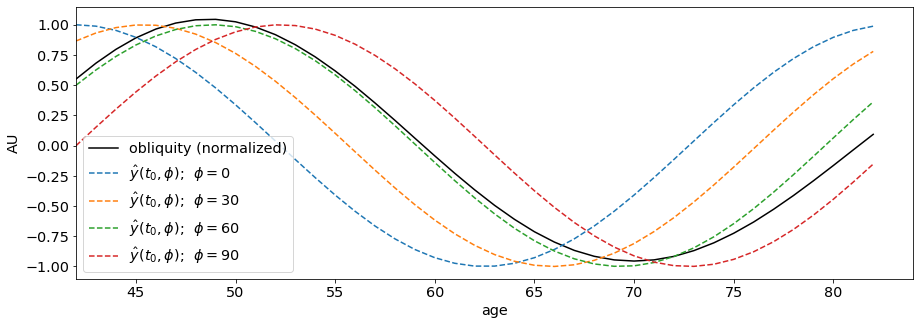

In [7]:
fig,ax=plt.subplots(1,1)
ax.plot(time,normalize(obliq[time]),'k',label='obliquity (normalized)')

ax.plot(time,y_hat(phi=0),'--',label='$\hat y(t_0,\phi)$;  $\phi=0$')
ax.plot(time,y_hat(phi=-30),'--',label='$\hat y(t_0,\phi)$;  $\phi=30$')
ax.plot(time,y_hat(phi=-60),'--',label='$\hat y(t_0,\phi)$;  $\phi=60$')
ax.plot(time,y_hat(phi=-90),'--',label='$\hat y(t_0,\phi)$;  $\phi=90$')
#ax.vlines(t0,-1,1,'k')
ax.legend();
ax.set_xlabel('age')
ax.set_ylabel('AU')
ax.set_xlim(left=t0)

## Phase estimation
At any point $t_0$ we compute the phase of obliquity by finding the phase difference $\phi$ that minimizes the misfit over the 41 ka preceeding $t_0$ between the normalized obliquity and a shifted cosine 
$$\phi =\text{argmin} J(\phi,t_0)$$  
$$J(\phi, t_0)=\sum_{t=t_0}^{t_0+41}\left[ y(t)-\cos\left(2\pi\frac{t-t_0}{T} +\phi\right)  \right]^2$$

In [8]:
# compute phase
def J_cost(phi,y):
    res=np.sum((normalize(y)-y_hat(phi))**2)
    return res

obliq_phase=np.zeros(700)
t0=np.arange(700)

for j in np.arange(700):
    time=t0[j]+np.arange(41)
    y=obliq[j:j+41]
    out=optimize.least_squares(J_cost,0,args=[y]);
    obliq_phase[j]=out.x[0]

We can plot the phase of obqliquity (normalized such that $-180^\circ:180^\circ$ corresponds to $-1:1$). Our estimation seems to have worked pretty well. Notice that the obliquity minima correspond to $\phi=-1\equiv 180^\circ$ degrees of phase difference, and the obliquity maxima correspond to a phase of $\phi=0\equiv 0^\circ$

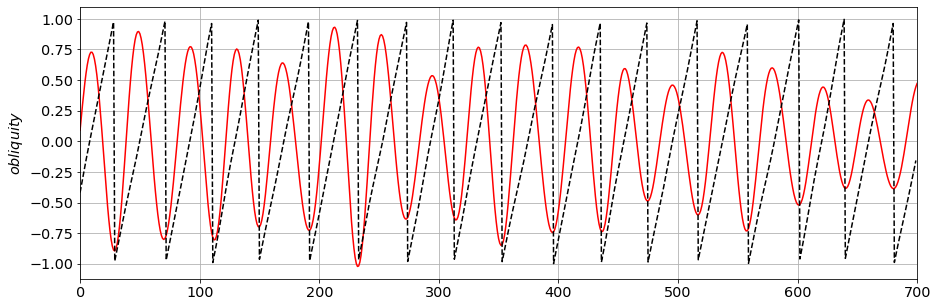

In [9]:
fig,ax=plt.subplots(1,1)
ax.plot(orb_age,normalize(obliq),'r')
ax.set_ylabel('$obliquity$');
ax.set_xlim(left=0,right=700)
ax.plot(orb_age[0:700],obliq_phase/180,'k--')
ax.grid()

Next we'll evaluate the phase of obliquity at glacial terminations, plot the phasors and compute Rayleigh's R (Fig.1 in Huybers & Wunsch 2004).

In [10]:
# compute the phase of obliquity at terminations and transform the phase in radians
phi_obliq_terms    =obliq_phase[np.asarray(terminations)]*np.pi/180

# compute Raileigh's R
R_obliq=1/8*np.abs(np.sum(np.cos(phi_obliq_terms)+1j*np.sin(phi_obliq_terms)))

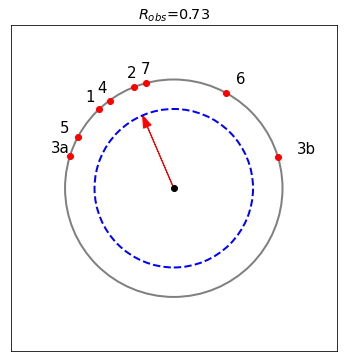

In [11]:
fig, ax = plt.subplots(1,1,figsize=[6,6])

x=-np.sin(phi_obliq_terms)
y=np.cos(phi_obliq_terms)
labels=['7','6','5','4','3b','3a','2','1']

circle_1 = plt.Circle(( 0 , 0 ), radius=1,facecolor='None' ,edgecolor=[0.5,0.5,0.5],linewidth=2)
circle_r = plt.Circle(( 0 , 0 ), radius=R_obliq,facecolor='None' ,edgecolor='b',linewidth=2,linestyle='--')

ax.add_artist(circle_1)
ax.add_artist(circle_r)
ax.arrow(0,0,1/8*np.sum(x),1/8*np.sum(y),length_includes_head=True,head_width=0.075,color='r')
ax.plot(x,y,'ro')
ax.plot(0,0,'ko')

ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect( 1 )
ax.set_xlim(left=-1.5,right=1.5)
ax.set_ylim(bottom=-1.5,top=1.5)
ax.set_title('$R_{obs}$='+np.array2string(R_obliq,precision=2))

for j in range(8):
    ax.annotate(labels[j],(x[j],y[j]),textcoords='offset points',xytext=(x[j]*20,y[j]*10),fontsize=15)

    



# The Null Hypothesis

Rayleigh's R is the test statistic for our null hypothesis test. It is  measure of how tight are obliquity and terminations coupled.

We want to know whether such tight coupling could arise by chance. To do so will generate a null hypothesis wherein glacial terminations are not affected by obliquity. We will then compute the $R$ statistic between obliquity and this model for termination. The model is described in Huybers & Wunsch 2004:

$$ \text{if } V_t<T_0:\;V_{t+1}=V_t+\eta_t$$ 

where $\eta_t \sim \mathcal N (\mu=1,\sigma=2)$. The non-zero mean will cause an average increase in ice volume. When the ice volume crosses the threshold $V_t>T_0$, it will deglaciate completely over a period of 10 kyr. 

In [12]:
from scipy import stats

def H0(obliq_phase):
    V=np.zeros(700)   #initialize ice volume
    t=699             #starting point
    T0=90             #threshold for deglaciation
    terminations=[]   #list to store time of termination
    
    while t>0:    
        if V[t]<T0:    # below threshold
            V[t-1]=V[t]+stats.norm.rvs(loc=1.1,scale=2,size=1) 
            t=t-1;        
        elif t>10:     #crossing threshold at >10ky before present
            terminations.append(t-5)            #note termination
            V[t-10:t]=np.linspace(0,V[t],10)  #deglaciate in 10kye
            t=t-10                            
        else:          
            #we have an exception to catch.
            #if we cross the threshold with less than 10ky left before present day, 
            # we can't just skip 10ky. 
            
            V[0:t]=np.linspace(0,V[t],10)[-t:]  #only keep data until present day
            if t>=5:    
                terminations.append(t-5)
            t=0

    np.size(terminations)
    phi_obliq_terms    =obliq_phase[np.asarray(terminations)]*np.pi/180
    R_obliq=1/8*np.abs(np.sum(np.cos(phi_obliq_terms)+1j*np.sin(phi_obliq_terms)))

        
    return R_obliq, terminations,phi_obliq_terms,V

# Generate a realizatoin of the null hypothesis
R_obliq_H0,terminations_H0,phi_obliq_terms_H0,V=H0(obliq_phase)

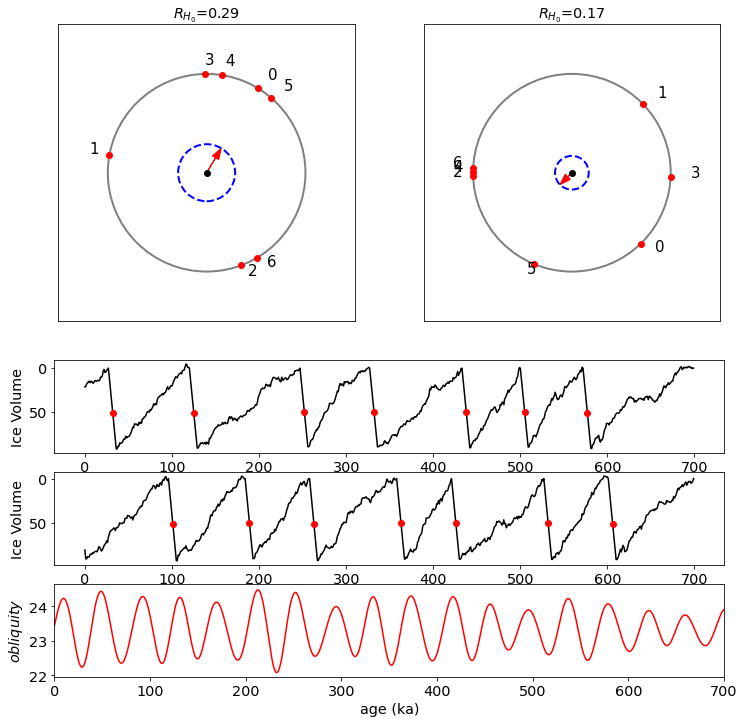

In [13]:
fig, ax = plt.subplots(4,1,figsize=[12,12])
for k in range(2):

    R_obliq_H0,terminations_H0,phi_obliq_terms_H0,V=H0(obliq_phase)
    plt.subplot(2,2,k+1)
    ax=plt.gca()
    x=-np.sin(phi_obliq_terms_H0)
    y=np.cos(phi_obliq_terms_H0)
    labels=np.arange(np.size(terminations_H0))

    circle_1 = plt.Circle(( 0 , 0 ), radius=1,facecolor='None' ,edgecolor=[0.5,0.5,0.5],linewidth=2)
    circle_r = plt.Circle(( 0 , 0 ), radius=R_obliq_H0,facecolor='None' ,edgecolor='b',linewidth=2,linestyle='--')

    ax.add_artist(circle_1)
    ax.add_artist(circle_r)
    ax.arrow(0,0,1/8*np.sum(x),1/8*np.sum(y),length_includes_head=True,head_width=0.075,color='r')
    ax.plot(x,y,'ro')
    ax.plot(0,0,'ko')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect( 1 )
    ax.set_xlim(left=-1.5,right=1.5)
    ax.set_ylim(bottom=-1.5,top=1.5)
    ax.set_title('$R_{H_0}$='+np.array2string(R_obliq_H0,precision=2))


    for j in range(np.size(terminations_H0)):
        ax.annotate(labels[j],(x[j],y[j]),textcoords='offset points',xytext=(x[j]*20,y[j]*10),fontsize=15)

    plt.subplot(6,1,k+4)
    ax=plt.gca()
    ax.plot(V,'k')
    ax.plot(terminations_H0,V[terminations_H0],'ro')
    ax.set_ylabel('Ice Volume');
    ax.invert_yaxis()
    
plt.subplot(6,1,6)

ax=plt.gca()
ax.plot(orb_age,obliq,'r')
ax.set_ylabel('$obliquity$');
ax.set_xlabel('age (ka)');
ax.set_xlim(0,700);

# Exercises:

## Exercise 1: Evaluate $H_0$
Generate a distribution of the null hypothesis, $H_0$, that is a distribution of the R-statistic for samples of the noise-model. Evaluate the p-value for the R-statistics of the glacial terminations.

Can we still reject the null hypothesis, despite our simpler approach? 

## Exercise 2: Alternate hypothesis $H_1$
Generate an alternate hypothesis $H_1$ as described in Eqn (2) in Huybers & Wunsch 2004. Plot the histogram of $H_1$ on top of the histogram $H_0$, along with the observed value of $R$. 

Are the observations consistent with the alternate hypothesis? 

What is the power of the test?

## Exercise 3: Time between terminations

Reproduce the distribution of time between terminations for both the null hypothesis $H_0$, and the alternate hypothesis $H_1$, and overlay the observed time between terminations. The distribution for $H_1$ is plotted in Figure 2d in Huybers Wunsch 2004. 


In [20]:
R_obliq_H0=np.zeros(5000)
for j in range(5000):    
    R_obliq_H0[j],terminations_H0,phi_obliq_terms_H0,V=H0(obliq_phase)
    

(array([ 21.,  66., 103., 146., 185., 226., 259., 248., 265., 287., 268.,
        324., 273., 279., 262., 235., 213., 218., 187., 168., 140., 125.,
        110.,  92.,  73.,  63.,  46.,  36.,  23.,  18.,  17.,   7.,   7.,
          6.,   1.,   1.,   0.,   0.,   1.,   1.]),
 array([0.00131859, 0.02525541, 0.04919224, 0.07312906, 0.09706588,
        0.1210027 , 0.14493952, 0.16887634, 0.19281316, 0.21674998,
        0.2406868 , 0.26462362, 0.28856044, 0.31249726, 0.33643409,
        0.36037091, 0.38430773, 0.40824455, 0.43218137, 0.45611819,
        0.48005501, 0.50399183, 0.52792865, 0.55186547, 0.57580229,
        0.59973911, 0.62367594, 0.64761276, 0.67154958, 0.6954864 ,
        0.71942322, 0.74336004, 0.76729686, 0.79123368, 0.8151705 ,
        0.83910732, 0.86304414, 0.88698096, 0.91091779, 0.93485461,
        0.95879143]),
 <BarContainer object of 40 artists>)

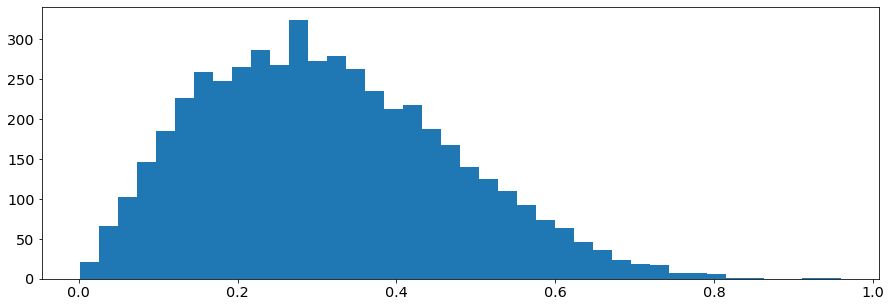

Text(0, 0.5, 'Occurence')

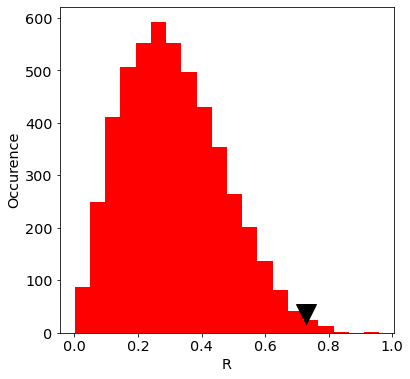

In [52]:
fig=plt.subplots(1,figsize=[6,6])
plt.hist(R_obliq_H0,20,facecolor='r')
p_obs=1-stats.percentileofscore(R_obliq_H0,0.73)/100
plt.plot(0.73,35,'vk',markersize=20)
plt.xlabel('R')
plt.ylabel('Occurence')